<a href="https://colab.research.google.com/github/pmckim1/NLP_News_Project/blob/main/News_LDA_Election_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install pyLDAvis
!pip install gensim --upgrade
! pip show gensim


     |████████████████████████████████| 1.6MB 7.4MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=f02029123b86ad478d021435d3fd0d8282396fc088e923fa5fc22358a44c0bd8
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis
     |████████████████████████████████| 24.2MB 1.4MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
Name: gensim
Version: 3.8.3
Summary: Python framework for fast Vector Space Modelling
Home-page: http://radimrehurek.com/gensim
Author: Radim Rehurek
Author-email: me@radimrehurek.com
License: LGPLv2.1
Location: /usr/local/lib/python3.6/dist-packages
Requires: smart-open, scipy, numpy, six
Required-by: 


# Creating an LDA model of News Articles using gensim + pyLDAvis 




In [ ]:
import gensim
import re
import random
import pyLDAvis

import numpy as np
import pandas as pd
import seaborn as sns
import pyLDAvis.gensim as gensimvis

from gensim.models.ldamulticore import LdaMulticore

from gensim.models.coherencemodel import CoherenceModel
from gensim.utils import simple_preprocess
from nltk.stem import SnowballStemmer
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.model_selection import train_test_split


import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
#define lemmatizer for later 
wordnet_lemmatizer = WordNetLemmatizer()
%matplotlib inline

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
from google.colab import drive
import sys
import pandas as pd
# Mount Google Drive
drive.mount('/content/drive')

# Get the absolute path of the current folder
abspath_curr = '/content/drive/My Drive/nlpproj/'

#data_set = pd.read_csv(abspath_curr + 'Guardian.csv')
datanews = pd.read_csv(abspath_curr +'eleweeks.csv', header=0)
#datanews= data_set["text"]

Mounted at /content/drive


## 1.  Data exploration

In [ ]:
len(datanews)

697

In [ ]:
len(pd.unique(datanews['text']))

696

In [ ]:
list(datanews)

['article number',
 'headline',
 'webPublicationDate',
 'text',
 'snippet',
 'section',
 'source',
 'week']

In [ ]:
datanews[["headline", "webPublicationDate", "text", "source"]].head()

,headline,webPublicationDate,text,source
0,"Among French Muslims, a Growing Feeling ‘That ...",10/29/20,"At age 42, Mehdy Belabbas embodied the French...",NYT
1,"As Cases Leap, Chastened Dutch Wonder, ‘What H...",10/29/20,As coronavirus cases have shot through the ro...,NYT
2,"As the West Stumbles, ‘Helmsman’ Xi Pushes an ...",10/29/20,The United States is embroiled in a bitter pre...,NYT
3,North Carolina Survey Gives Democrats Edge,10/29/20,Joseph R. Biden Jr. holds a small but durable ...,NYT
4,Trump Allies Try to Curb Early Pennsylvania Votes,10/29/20,President Trump’s campaign in the crucial bat...,NYT


## 2.  Data Preparation

In [ ]:
# A quick utility function to pre-process the text using lemmitization 
def preprocess_desc(description):
    return( [wordnet_lemmatizer.lemmatize(token) for token in simple_preprocess(str(description)) if token not in STOPWORDS] )

In [ ]:
# NB;  This step could be improved through first filtering to words that are pronouns.
datanews['tokens'] = datanews['text'].apply(preprocess_desc)

In [ ]:
datanews[["headline", "webPublicationDate", "text", "source", "tokens"]].tail()

,headline,webPublicationDate,text,source,tokens
692,"UK death toll from Covid-19 passes 50,000",11/11/20,"The UK’s Covid-19 death toll has surpassed 50,...",Guardian,"[uk, covid, death, toll, surpassed, government..."
693,UK government must condemn Trump denial of def...,11/11/20,The government should condemn Donald Trump’s r...,Guardian,"[government, condemn, donald, trump, refusal, ..."
694,US Covid response must tie economic recovery t...,11/11/20,Politicians and officials leading the US respo...,Guardian,"[politician, official, leading, response, covi..."
695,Vote Leave's Lee Cain tipped as next Downing S...,11/11/20,"One of Boris Johnson’s most loyal allies, Lee ...",Guardian,"[boris, johnson, loyal, ally, lee, cain, consi..."
696,‘We’re in power now’: Evo Morales makes gleefu...,11/11/20,Tens of thousands of jubilant followers have w...,Guardian,"[ten, thousand, jubilant, follower, welcomed, ..."


## 3. Create TF-IDF representation

In [ ]:
# Create the vocabulary record
dictionary = gensim.corpora.Dictionary(datanews['tokens'])

In [ ]:
# Remove extreme values (words that are too rare, too common)
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=100000)

In [ ]:
# Create a BOW model
bow_corpus = [dictionary.doc2bow(doc) for doc in datanews['tokens']]

In [ ]:
# From that create the TF-IDF model
tfidf = gensim.models.TfidfModel(bow_corpus)
datanews['corpus_tfidf'] = tfidf[bow_corpus]

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
datanews['corpus_tfidf'].head()

0    [(0, 0.18457289912755137), (1, 0.2542274360546...
1    [(22, 0.12240338474533471), (23, 0.08583755197...
2    [(27, 0.08219111581667601), (43, 0.26677780779...
3    [(40, 0.07179253753202978), (60, 0.14110360743...
4    [(55, 0.07358474567039286), (61, 0.19149089377...
Name: corpus_tfidf, dtype: object

## 4.  Create LDA models 
Train-test split only, because I'm not iteratively improving anything

In [ ]:
random.seed(10)
trainset, testset = train_test_split(datanews, test_size=0.20)

In [ ]:
# Loop through a number of different topic model sizes
# this cell is very slow!!! reduce range size to speed it up; we tested additional numbers in testing phase but reduce it here to improve run time  

results = pd.DataFrame()

for num_topics in range(25, 50):
    lda_model_tfidf = LdaMulticore(trainset['corpus_tfidf'],
                               num_topics=num_topics,
                               id2word=dictionary,
                               passes=2)
    
    # Get the perplexity
    perplexity = lda_model_tfidf.log_perplexity(testset['corpus_tfidf'])
    
    # Get the coherence
    # Get the coherence
    cm = CoherenceModel(model=lda_model_tfidf, corpus=testset['corpus_tfidf'], coherence='u_mass')
    #try:
    coherence = cm.get_coherence()
    #except Exception as e:

    
    # record
    results = results.append({"topics":num_topics, "perplexity":perplexity, "coherence":coherence}, ignore_index=True)
    
    # Report for my convenience
    print("tried {} topics".format(num_topics), "perplexity = {}".format(perplexity), "coherence = {}".format(coherence))

results.to_csv("tested_lda_stats_clean.csv")

# Compute Coherence Score using c_v


 #with np.errstate(invalid='ignore'):
  #    coherence = cm.get_coherence()


tried 25 topics perplexity = -28.092059551817645 coherence = -11.827770386128616
tried 26 topics perplexity = -28.952079605293736 coherence = -11.581880313738083
tried 27 topics perplexity = -29.730968377031903 coherence = -12.517387552561972
tried 28 topics perplexity = -29.4607235834323 coherence = -13.166964558135179
tried 29 topics perplexity = -30.3921855559362 coherence = -12.492312006064651
tried 30 topics perplexity = -31.006717469663005 coherence = -12.274823676533353
tried 31 topics perplexity = -31.898986233818565 coherence = -12.325996505502847
tried 32 topics perplexity = -32.02982999484219 coherence = -13.60825877578
tried 33 topics perplexity = -32.88791656149543 coherence = -12.927101981648537
tried 34 topics perplexity = -33.692822708785485 coherence = -12.552061214400364
tried 35 topics perplexity = -34.08078494944668 coherence = -12.907514204246374
tried 36 topics perplexity = -34.29496471726499 coherence = -12.583230120359099
tried 37 topics perplexity = -35.5149584

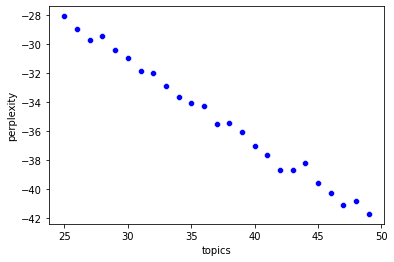

In [ ]:
# plot the results
sns.scatterplot(x="topics", y="perplexity", color="blue", data=results)

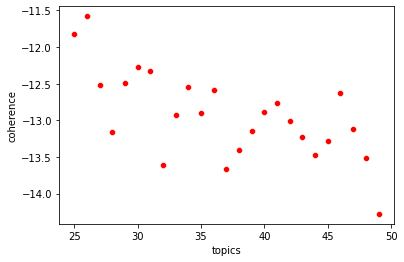

In [ ]:
# plot the results
sns.scatterplot(x="topics", y="coherence", color="red", data=results)

## 5.  Create the "Best" Model for our purposes
We want smaller tighter clusters to achieve out goal of grouping together news stories about the same event, previous gaphs suggested 33 for num_topics will work well 


In [ ]:
random.seed(10)

# Fit the final lda model to all data
lda_model_tfidf = LdaMulticore(datanews['corpus_tfidf'],
                           num_topics=33,
                           id2word=dictionary,
                           passes=2)

# Get the perplexity, out of curiosity
perplexity = lda_model_tfidf.log_perplexity(datanews['corpus_tfidf'])
    
# Get the coherence, out of curiosity
cm = CoherenceModel(model=lda_model_tfidf, corpus=datanews['corpus_tfidf'], coherence='u_mass')
coherence = cm.get_coherence()

print("perplexity = {}".format(perplexity), "coherence = {}".format(coherence))

perplexity = -16.721123002802756 coherence = -8.47078993612335


In [ ]:
# quick look at the topics picked out
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.012*"corbyn" + 0.009*"antisemitism" + 0.008*"party" + 0.008*"labour" + 0.006*"ehrc" + 0.004*"suspension" + 0.004*"jeremy" + 0.004*"complaint" + 0.003*"starmer" + 0.003*"dog"
Topic: 1 Word: 0.004*"abortion" + 0.003*"poland" + 0.003*"vote" + 0.003*"election" + 0.003*"ireland" + 0.003*"eu" + 0.002*"war" + 0.002*"student" + 0.002*"ban" + 0.002*"boy"
Topic: 2 Word: 0.008*"mink" + 0.006*"form" + 0.005*"denmark" + 0.005*"contact" + 0.004*"mutation" + 0.004*"tax" + 0.003*"encrypted" + 0.003*"click" + 0.003*"contribution" + 0.003*"farm"
Topic: 3 Word: 0.004*"battleground" + 0.004*"victory" + 0.003*"downing" + 0.003*"question" + 0.002*"party" + 0.002*"china" + 0.002*"resistance" + 0.002*"pennsylvania" + 0.002*"australia" + 0.002*"diagnosis"
Topic: 4 Word: 0.004*"sexual" + 0.003*"bike" + 0.003*"morale" + 0.003*"senator" + 0.003*"hotel" + 0.003*"bolivia" + 0.003*"swept" + 0.003*"referendum" + 0.003*"weather" + 0.002*"anxious"
Topic: 5 Word: 0.004*"storm" + 0.003*"app" + 0.003*"aus

## Create Visualization of resulting clusters (Interactive Graphs)

In [ ]:
vis_data = gensimvis.prepare(lda_model_tfidf, datanews['corpus_tfidf'], dictionary, mds='mmds') 

In [ ]:
pyLDAvis.display(vis_data)

In [ ]:
# Let's take a quick look at words the topics picked out
topic_word_dist = pd.DataFrame()

for idx, topic in lda_model_tfidf.print_topics(-1):
    
    topic_index = "X" + str(idx)
    
    # Record the topic's key words as a single string
    # Split the words with a newline character
    topic_words = " ".join([x.split("*")[1].replace('"', '').strip() for x in topic.split("+")][0:5])
    
    # Dump them to the results dataframe
    topic_word_dist = topic_word_dist.append({"topic":topic_index, "keywords":topic_words}, ignore_index=True)

In [ ]:
topic_word_dist

,keywords,topic
0,corbyn antisemitism party labour ehrc,X0
1,abortion poland vote election ireland,X1
2,mink form denmark contact mutation,X2
3,battleground victory downing question party,X3
4,sexual bike morale senator hotel,X4
5,storm app australian australia azerbaijan,X5
6,jr joseph biden documented trump,X6
7,trump victory change president administration,X7
8,turkey eu lord agreement turkish,X8
9,police protest lockdown regulation storm,X9
